In [1]:
# Step 0: Setup
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")


In [2]:
#Step 1: Load datasets
# ============================
temp = pd.read_csv("temperature.csv")
hum  = pd.read_csv("humidity.csv")
pres = pd.read_csv("pressure.csv")

# Convert datetime
for df in [temp, hum, pres]:
    df['datetime'] = pd.to_datetime(df['datetime'])




In [3]:
#Step 2: Merge datasets
# ============================
merged = temp.merge(hum, on="datetime", suffixes=("_temp", "_hum"))
merged = merged.merge(pres, on="datetime", suffixes=("", "_pres"))



In [4]:
#Step 3: Extract one city
# ============================
city = "Montreal"   # <-- change this to any city you like

df_city = merged[['datetime',
                  f"{city}_temp",
                  f"{city}_hum",
                  city]]  # pressure file has no suffix

df_city = df_city.rename(columns={
    f"{city}_temp": "temperature",
    f"{city}_hum": "humidity",
    city: "pressure"
})

df_city = df_city.set_index("datetime").sort_index()



In [5]:
#Step 4: Clean & resample
# ============================
# Resample to daily averages
df_daily = df_city.resample("D").mean()

# Handle missing values (forward fill)
df_daily = df_daily.fillna(method="ffill")




C:\Users\kpnar\AppData\Local\Temp\ipykernel_5524\1981721879.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily = df_daily.fillna(method="ffill")


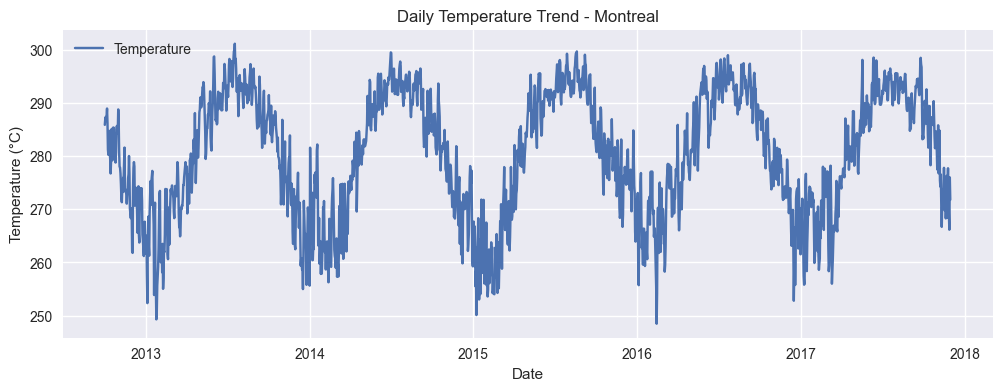

In [6]:
#Step 5: Visualize trends
# ============================
plt.figure(figsize=(12,4))
plt.plot(df_daily['temperature'], label="Temperature")
plt.title(f"Daily Temperature Trend - {city}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()




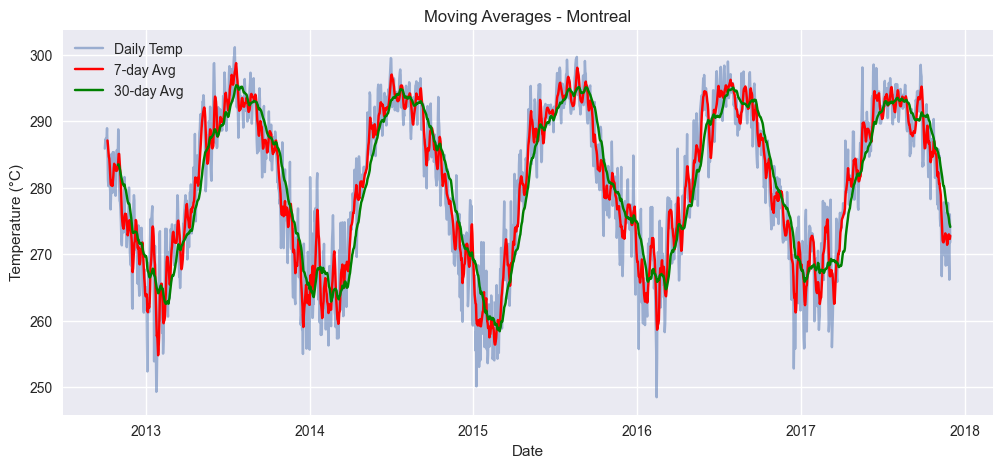

In [7]:
#Step 6: Moving averages
# ============================
df_daily['sma7'] = df_daily['temperature'].rolling(7).mean()
df_daily['sma30'] = df_daily['temperature'].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(df_daily['temperature'], label="Daily Temp", alpha=0.5)
plt.plot(df_daily['sma7'], label="7-day Avg", color="red")
plt.plot(df_daily['sma30'], label="30-day Avg", color="green")
plt.title(f"Moving Averages - {city}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [8]:
# Step 7: Feature engineering
# ============================
# Add lag features
df_daily['lag1']  = df_daily['temperature'].shift(1)   # yesterday
df_daily['lag7']  = df_daily['temperature'].shift(7)   # last week
df_daily['lag30'] = df_daily['temperature'].shift(30)  # last month

# Drop rows with NaN
df_model = df_daily.dropna()

# Features and target
X = df_model[['lag1', 'lag7', 'lag30', 'humidity', 'pressure']]
y = df_model['temperature']



In [9]:
# Step 8: Train/Test Split
# ============================
# Train on 2012–2016, test on 2017
train = df_model.loc[:'2016-12-31']
test  = df_model.loc['2017-01-01':]

X_train, y_train = train[X.columns], train['temperature']
X_test,  y_test  = test[X.columns],  test['temperature']

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (1523, 5) Test size: (334, 5)


In [10]:
#Step 9: Train model
# ============================
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
# Step 10: Predict & Evaluate
# ============================
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))




Train MAE: 2.758514991333974
Train RMSE: 3.6121213863935484
Test MAE: 2.5174715250194004
Test RMSE: 3.2663734325256084


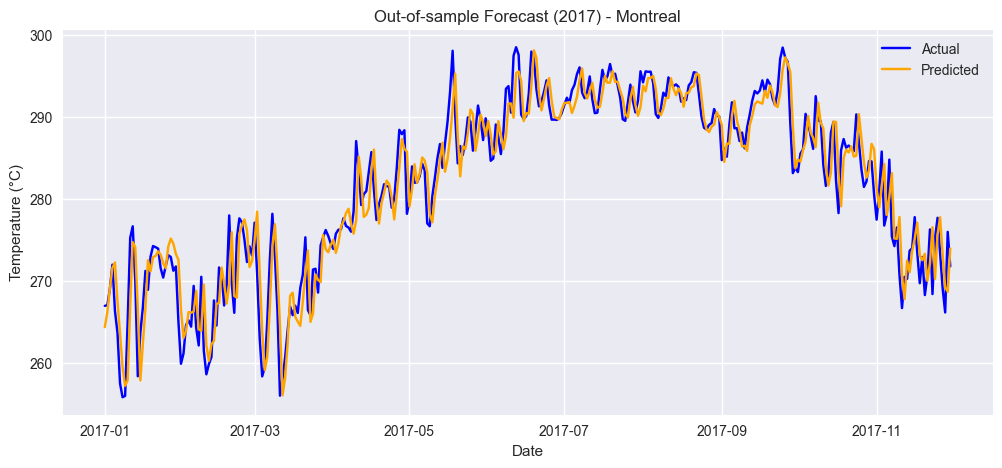

In [12]:
# Step 11: Plot results
# ============================
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred_test, label="Predicted", color="orange")
plt.title(f"Out-of-sample Forecast (2017) - {city}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


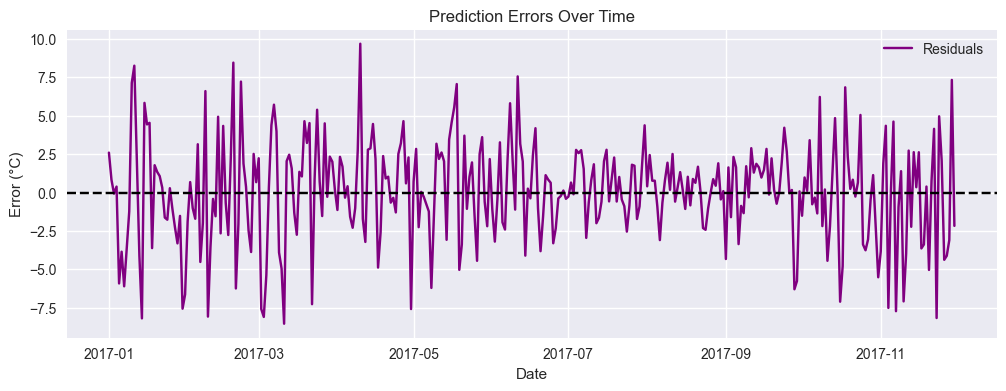

In [13]:
# Step 12: Residual analysis
# ============================
residuals = y_test - y_pred_test
plt.figure(figsize=(12,4))
plt.plot(y_test.index, residuals, label="Residuals", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.title("Prediction Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Error (°C)")
plt.legend()
plt.show()


In [14]:
df_model['predicted'] = model.predict(X)
print(df_model[['temperature', 'predicted']].head())
print(df_model[['temperature', 'predicted']].tail())

            temperature   predicted
datetime                           
2012-10-31   288.785833  285.369540
2012-11-01   286.332083  288.669984
2012-11-02   280.717083  286.926863
2012-11-03   278.019167  282.946993
2012-11-04   277.856458  280.184498
            temperature   predicted
datetime                           
2017-11-26   273.407083  277.786866
2017-11-27   269.104167  273.222284
2017-11-28   266.159042  269.249528
2017-11-29   275.997917  268.667473
2017-11-30   271.800000  273.968991


C:\Users\kpnar\AppData\Local\Temp\ipykernel_5524\2121241517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['predicted'] = model.predict(X)
